In [30]:
from src.utils import *
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [9]:
df_train, df_test_kaggle, data_dict = load_tabular_data('data/train.csv', 'data/test.csv', 'data/data_dictionary.csv')

### Add features extracted from time series data
(for more information, see the notebook `visualization/plot_series.ipynb`)

In [10]:
df_train = add_series_features(df_train, 'data/series_train.parquet')
df_test_kaggle = add_series_features(df_test_kaggle, 'data/series_test.parquet')

### Split data into training and private test set

In [11]:
y = df_train['sii']
X_train, X_test, _, _ = train_test_split(df_train, y, test_size=0.2, random_state=42)

In [12]:
# Remove columns not in test set (not important)
columns_not_in_test = list(set(df_train.columns).difference(set(df_test_kaggle.columns)))
columns_not_in_test.remove('sii')
X_train = X_train.drop(columns=columns_not_in_test)
X_test = X_test.drop(columns=columns_not_in_test)

### Outlier detection
(for more information, see the notebook `visualization/plot_features.ipynb`)

In [13]:
# CGAS score should be between 0 and 100
X_train.loc[X_train['CGAS-CGAS_Score'] > 100, 'CGAS-CGAS_Score'] = np.nan
X_train.loc[X_train['CGAS-CGAS_Score'] < 0, 'CGAS-CGAS_Score'] = np.nan

physical_features = df_train.columns[df_train.columns.str.contains('Physical')]
# Replace 0 values for physical features with NaN
X_train[physical_features] = X_train[physical_features].replace(0, np.nan)

# Replace values where systolic blood pressure is less than diastolic blood pressure with NaN
condition = X_train['Physical-Systolic_BP'] < X_train['Physical-Diastolic_BP']
X_train.loc[condition, ['Physical-Systolic_BP', 'Physical-Diastolic_BP']] = np.nan

### Data imputation
- For the numerical features, we fill the missing values with the mean value in the column.
(KNN imputation was also tested, but it did not improve the performance of the model.)
- For the categorical features, we fill the missing values with the most frequent value in the column.

In [14]:
X_train, X_test = impute_tabdata(X_train, X_test, 'data/data_dictionary.csv')

### One hot encoding for categorical features

In [15]:
X_train = X_train.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

In [18]:
categorical_features = data_dict[(data_dict['Type'] == 'str') | (data_dict['Type'] == 'categorical int')]['Field'].values
categorical_features = [feature for feature in categorical_features if feature not in columns_not_in_test]
categorical_features.remove('id')

In [19]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features_train = encoder.fit_transform(X_train[categorical_features])
encoded_df_train = pd.DataFrame(encoded_features_train, columns=encoder.get_feature_names_out(categorical_features))
X_train = X_train.drop(columns=categorical_features)
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

encoded_features_test = encoder.transform(X_test[categorical_features])
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(categorical_features))
X_test = X_test.drop(columns=categorical_features)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

### Model
(Parameterers were selected based on the results of the notebook `experiment/xgb_baseline.ipynb`.)

In [20]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                              eval_metric='mlogloss', 
                              num_class=4, 
                              learning_rate=0.01, 
                              max_depth=2, 
                              min_child_weight=0, 
                              gamma=0, 
                              subsample=0.7, 
                              colsample_bytree=0.55,
                              reg_alpha=1e-5,
                              n_estimators=5000)

In [21]:
xgb_model.fit(X_train.dropna(subset=["sii"]).drop(columns=['sii']), 
              X_train.dropna(subset=["sii"])['sii'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5000,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

### Evaluation

In [22]:
eval = evaluate_model(xgb_model, X_test.dropna(subset=["sii"]).drop(columns=['sii']), 
                      X_test.dropna(subset=["sii"])['sii'])
print(f'XGB classifier model accuracy: {eval[1]}, kappa: {eval[0]}')

XGB classifier model accuracy: 0.6022099447513812, kappa: 0.35781604485443297


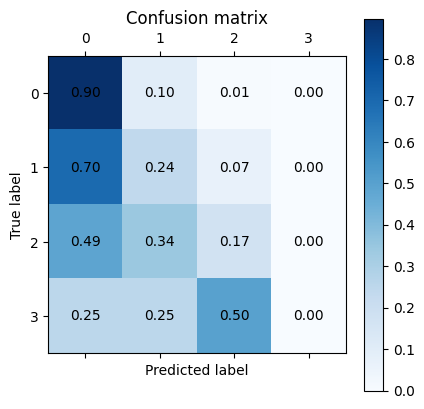

In [35]:
# confusion matrix
y_pred = xgb_model.predict(X_test.dropna(subset=["sii"]).drop(columns=['sii']))
cm = confusion_matrix(X_test.dropna(subset=["sii"])['sii'], y_pred, normalize='true')
plt.matshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

### Label propagation

In [ ]:
X_train = label_propagation(X_train, LabelPropagation())

### Oversampling
We used the SMOTE algorithm to oversample the minority classes.

In [ ]:
X_train = oversample_tabdata(X_train)

### Model

In [25]:
xgb_model_oversampled = xgb.XGBClassifier(objective='multi:softmax', 
                                          eval_metric='mlogloss', 
                                          num_class=4, 
                                          learning_rate=0.01, 
                                          max_depth=2, 
                                          min_child_weight=0, 
                                          gamma=0, 
                                          subsample=0.7, 
                                          colsample_bytree=0.55,
                                          reg_alpha=1e-5,
                                          n_estimators=5000)


In [26]:
xgb_model_oversampled.fit(X_train.drop(columns=['sii']), X_train['sii'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5000,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

### Evaluation

In [27]:
eval_oversampled = evaluate_model(xgb_model_oversampled, X_test.dropna(subset=["sii"]).drop(columns=['sii']), 
                                  X_test.dropna(subset=["sii"])['sii'])
print(f'XGB classifier model accuracy: {eval_oversampled[1]}, kappa: {eval_oversampled[0]}')

XGB classifier model accuracy: 0.5911602209944752, kappa: 0.30297009092887495


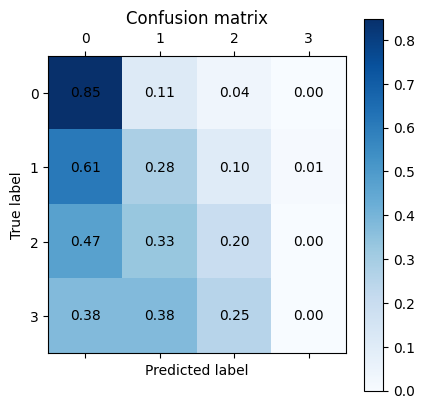

In [36]:
# confusion matrix
y_pred = xgb_model_oversampled.predict(X_test.dropna(subset=["sii"]).drop(columns=['sii']))
cm = confusion_matrix(X_test.dropna(subset=["sii"])['sii'], y_pred, normalize='true')
plt.matshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

### Feature importance

In [28]:
feature_importances = xgb_model.feature_importances_
feature_names = X_train.drop(columns=['sii']).columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

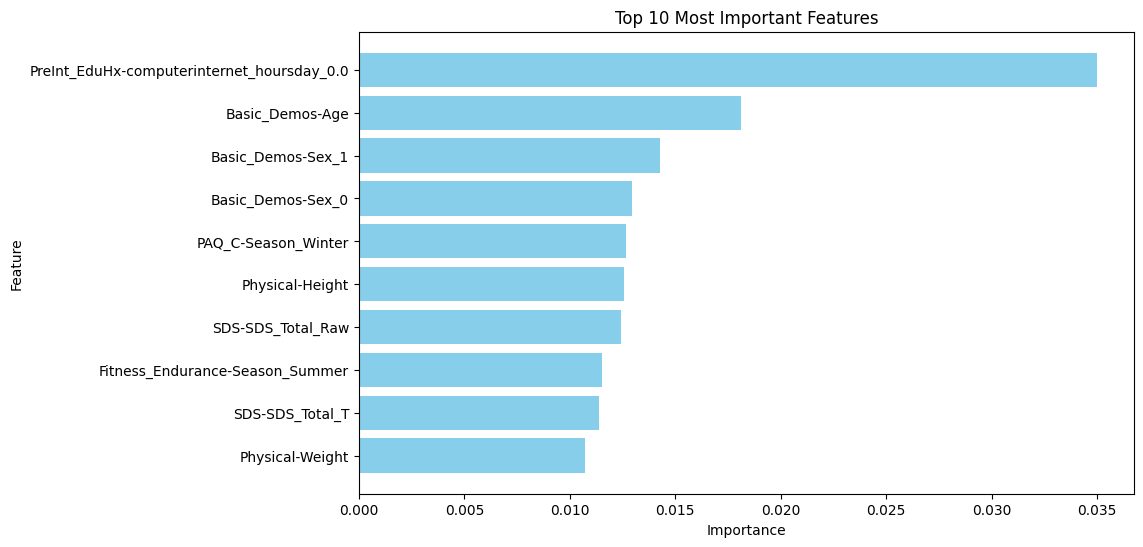

In [29]:
# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()